<a href="https://colab.research.google.com/github/Hruthikaveldi/23CSBTB29/blob/main/almost_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# 📦 Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, classification_report

# 📥 Load dataset
df = pd.read_csv('Mobiles_Dataset_2025.csv', encoding='latin1')
print("📌 Initial Dataset:")
print(df.head())  # See the first few rows of raw data

# 🧹 Step 1: Drop duplicates + fill missing values (forward fill)
df.drop_duplicates(inplace=True)
df.ffill(inplace=True)

# 🔧 Step 2: Clean 'RAM' and 'Battery Capacity' columns
df['RAM'] = df['RAM'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['Battery Capacity'] = df['Battery Capacity'].astype(str).str.replace(',', '').str.extract('(\d+\.?\d*)').astype(float)

# 💸 Step 3: Clean 'Launched Price (India)' by removing ₹, commas, etc.
df['Launched Price (India)'] = (
    df['Launched Price (India)']
    .astype(str)
    .str.replace('₹', '')
    .str.replace('INR', '')
    .str.replace(',', '')
    .str.extract('(\d+\.?\d*)')[0]
    .astype(float)
)

# 📱 Step 4: Clean 'Screen Size'
df['Screen Size'] = df['Screen Size'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

# 🤳 Step 5: Clean 'Front Camera'
df['Front Camera'] = df['Front Camera'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

# 📸 Step 6: Clean 'Back Camera' (extract max MP if multiple lenses given)
def extract_max_camera(value):
    if isinstance(value, str):
        nums = [float(n) for n in re.findall(r'\d+\.?\d*', value)]
        return max(nums) if nums else None
    return value

df['Back Camera'] = df['Back Camera'].apply(extract_max_camera)

# 🌍 Step 7: Clean other international price columns
price_cols = [
    'Launched Price (Pakistan)', 'Launched Price (China)',
    'Launched Price (USA)', 'Launched Price (Dubai)'
]

for col in price_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r'[^\d\.]', '', regex=True)
        .str.extract('(\d+\.?\d*)')[0]
        .astype(float)
    )


📌 Initial Dataset:
  Company Name            Model Name Mobile Weight  RAM Front Camera  \
0        Apple       iPhone 16 128GB          174g  6GB         12MP   
1        Apple       iPhone 16 256GB          174g  6GB         12MP   
2        Apple       iPhone 16 512GB          174g  6GB         12MP   
3        Apple  iPhone 16 Plus 128GB          203g  6GB         12MP   
4        Apple  iPhone 16 Plus 256GB          203g  6GB         12MP   

  Back Camera   Processor Battery Capacity Screen Size  \
0        48MP  A17 Bionic         3,600mAh  6.1 inches   
1        48MP  A17 Bionic         3,600mAh  6.1 inches   
2        48MP  A17 Bionic         3,600mAh  6.1 inches   
3        48MP  A17 Bionic         4,200mAh  6.7 inches   
4        48MP  A17 Bionic         4,200mAh  6.7 inches   

  Launched Price (Pakistan) Launched Price (India) Launched Price (China)  \
0               PKR 224,999             INR 79,999              CNY 5,799   
1               PKR 234,999             INR 8

In [36]:
# Encode Company Name
le = LabelEncoder()
df['Company_Encoded'] = le.fit_transform(df['Company Name'])

# 🧽 Step 9: Filter out mobiles with RAM > 12GB (keeping analysis practical)
df = df[df['RAM'] <= 12]

# 👀 Check cleaned data
print("\n📌 Cleaned Dataset Preview:")
print(df.head())


📌 Cleaned Dataset Preview:
  Company Name            Model Name Mobile Weight  RAM  Front Camera  \
0        Apple       iPhone 16 128GB          174g  6.0          12.0   
1        Apple       iPhone 16 256GB          174g  6.0          12.0   
2        Apple       iPhone 16 512GB          174g  6.0          12.0   
3        Apple  iPhone 16 Plus 128GB          203g  6.0          12.0   
4        Apple  iPhone 16 Plus 256GB          203g  6.0          12.0   

   Back Camera   Processor  Battery Capacity  Screen Size  \
0         48.0  A17 Bionic            3600.0          6.1   
1         48.0  A17 Bionic            3600.0          6.1   
2         48.0  A17 Bionic            3600.0          6.1   
3         48.0  A17 Bionic            4200.0          6.7   
4         48.0  A17 Bionic            4200.0          6.7   

   Launched Price (Pakistan)  Launched Price (India)  Launched Price (China)  \
0                   224999.0                 79999.0                  5799.0   
1     

<ipython-input-37-bd70dd7a821c>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ram_counts.index, y=ram_counts.values, palette=colors)
<ipython-input-37-bd70dd7a821c>:33: UserWarning: Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


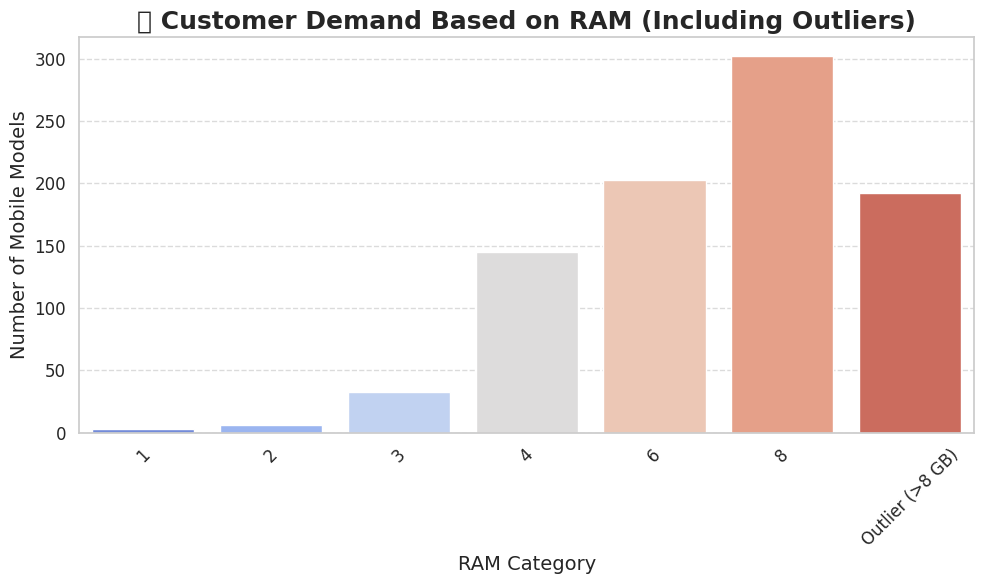

In [37]:
# 📊 Step 10: Scale selected numeric columns (for modeling later)
scaler = StandardScaler()
scale_cols = ['RAM', 'Screen Size', 'Battery Capacity', 'Launched Price (India)']
df_scaled = df.copy()
df_scaled[scale_cols] = pd.DataFrame(scaler.fit_transform(df[scale_cols]), columns=scale_cols)

# 🧠 Step 11: EDA — Customer Demand Based on RAM

import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Round RAM for clarity
df['RAM_Rounded'] = df['RAM'].round()

# Step 2: Label RAM > 8 as "Outlier"
df['RAM_Category'] = df['RAM'].apply(lambda x: str(int(x)) if x <= 8 else 'Outlier (>8 GB)')

# Step 3: Count models per category
ram_counts = df['RAM_Category'].value_counts().sort_index()

# Step 4: Plot
plt.figure(figsize=(10, 6))
colors = sns.color_palette("coolwarm", len(ram_counts))

sns.barplot(x=ram_counts.index, y=ram_counts.values, palette=colors)

# Make it sexy
plt.title("📱 Customer Demand Based on RAM (Including Outliers)", fontsize=18, weight='bold')
plt.xlabel("RAM Category", fontsize=14)
plt.ylabel("Number of Mobile Models", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

<ipython-input-38-e1c7def726f6>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="Launched Year", y="RAM", estimator='mean', ci=None, marker='o',


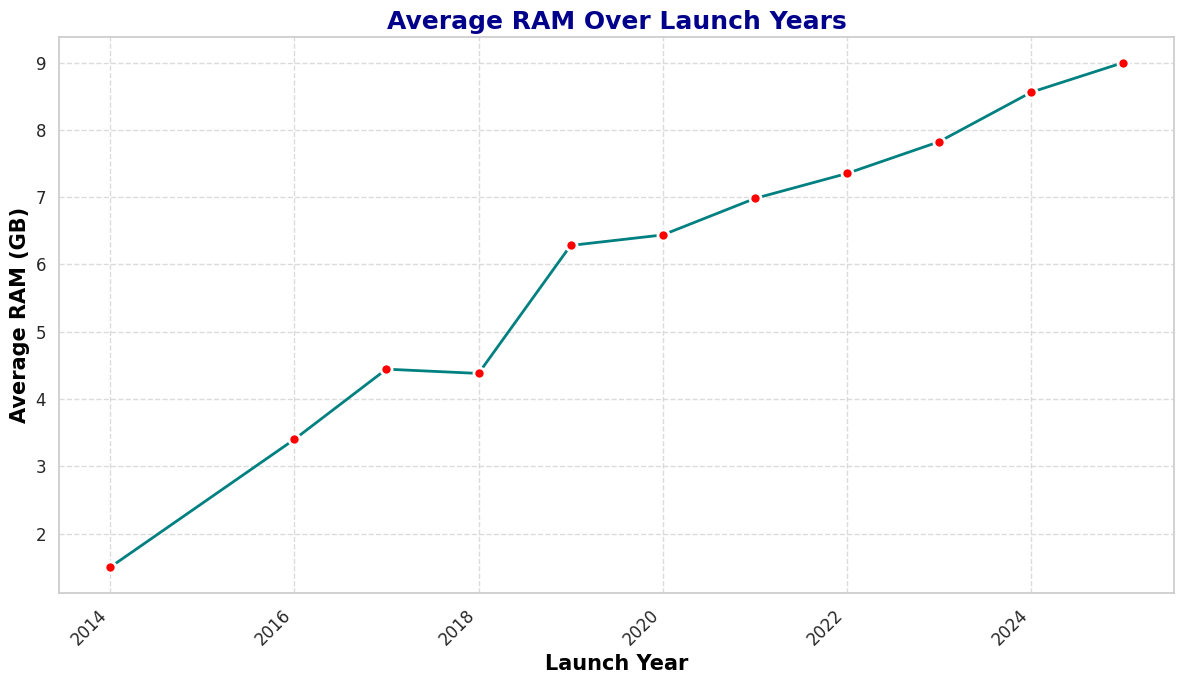

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(12, 7))

# Ensure RAM is numeric (extract numeric part)
df['RAM'] = df['RAM'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)

# Plot the average RAM over launch years with the original values
sns.lineplot(data=df, x="Launched Year", y="RAM", estimator='mean', ci=None, marker='o',
             color='teal', linewidth=2, markersize=8, markerfacecolor='red', markeredgewidth=2)

# Title and labels with custom fonts
plt.title("Average RAM Over Launch Years", fontsize=18, fontweight='bold', color='darkblue')
plt.xlabel("Launch Year", fontsize=15, fontweight='bold', color='black')
plt.ylabel("Average RAM (GB)", fontsize=15, fontweight='bold', color='black')

# Customize ticks
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Show a clean grid
plt.grid(True, linestyle='--', alpha=0.7)

# Tight layout for better fitting
plt.tight_layout()

# Show plot
plt.show()



In [40]:
# Function to detect outliers using IQR method
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]

# Detect outliers for RAM and Price
outliers_ram = detect_outliers(df, 'RAM')
outliers_price = detect_outliers(df, 'Launched Price (India)')

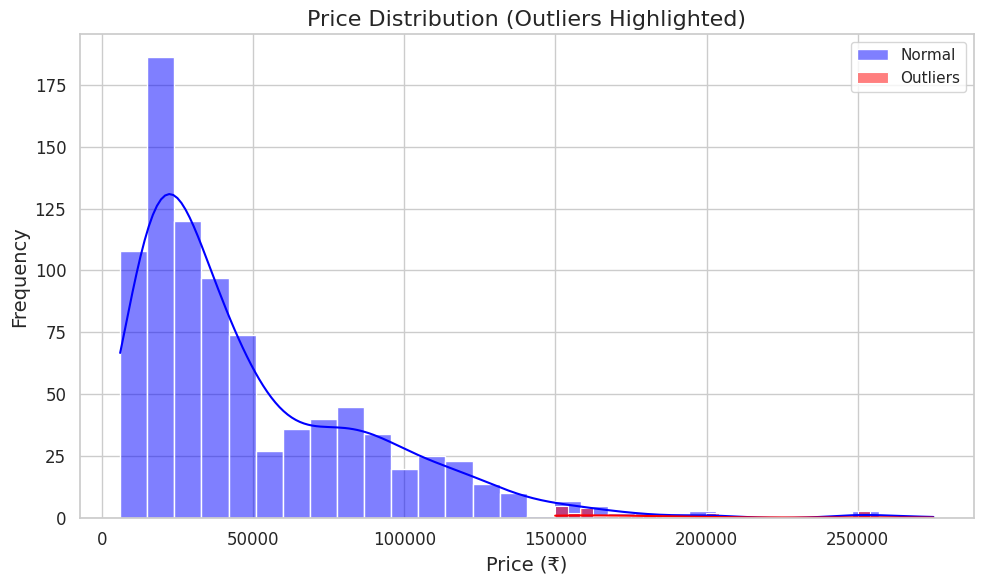

In [42]:
# EDA: Price Distribution (Histogram) with Outliers
plt.figure(figsize=(10, 6))
sns.histplot(df['Launched Price (India)'], bins=30, kde=True, color='blue', label='Normal')
sns.histplot(outliers_price['Launched Price (India)'], bins=30, kde=True, color='red', label='Outliers')
plt.title("Price Distribution (Outliers Highlighted)", fontsize=16)
plt.xlabel("Price (₹)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-43-931c3c424e94>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="Launched Year", y="Launched Price (India)", estimator='mean', ci=None, marker='o', label='Average Price')


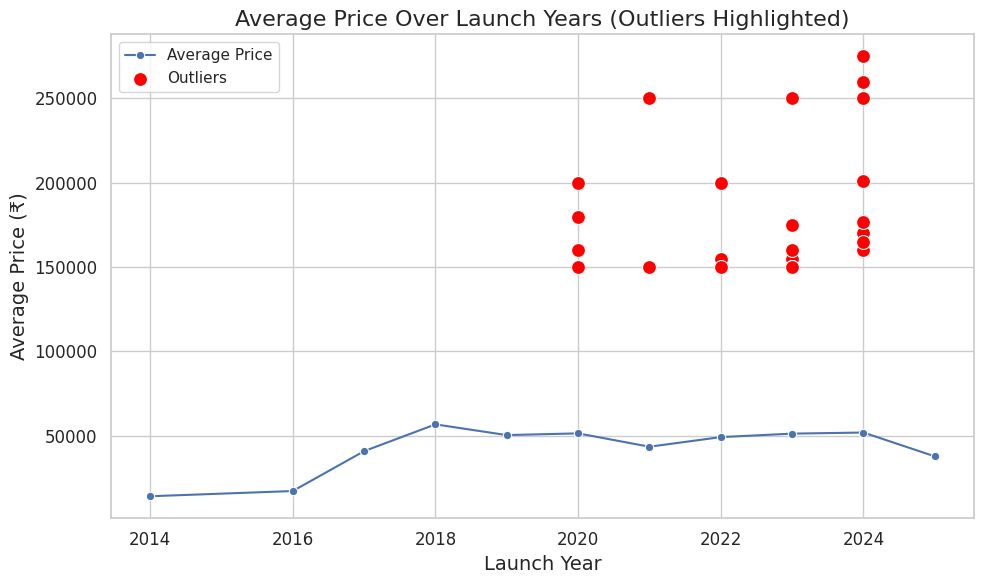

In [43]:
# EDA: Launch Year vs. Price (Average Price by Year) with Outliers
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Launched Year", y="Launched Price (India)", estimator='mean', ci=None, marker='o', label='Average Price')
sns.scatterplot(data=outliers_price, x="Launched Year", y="Launched Price (India)", color='red', label='Outliers', s=100)
plt.title("Average Price Over Launch Years (Outliers Highlighted)", fontsize=16)
plt.xlabel("Launch Year", fontsize=14)
plt.ylabel("Average Price (₹)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

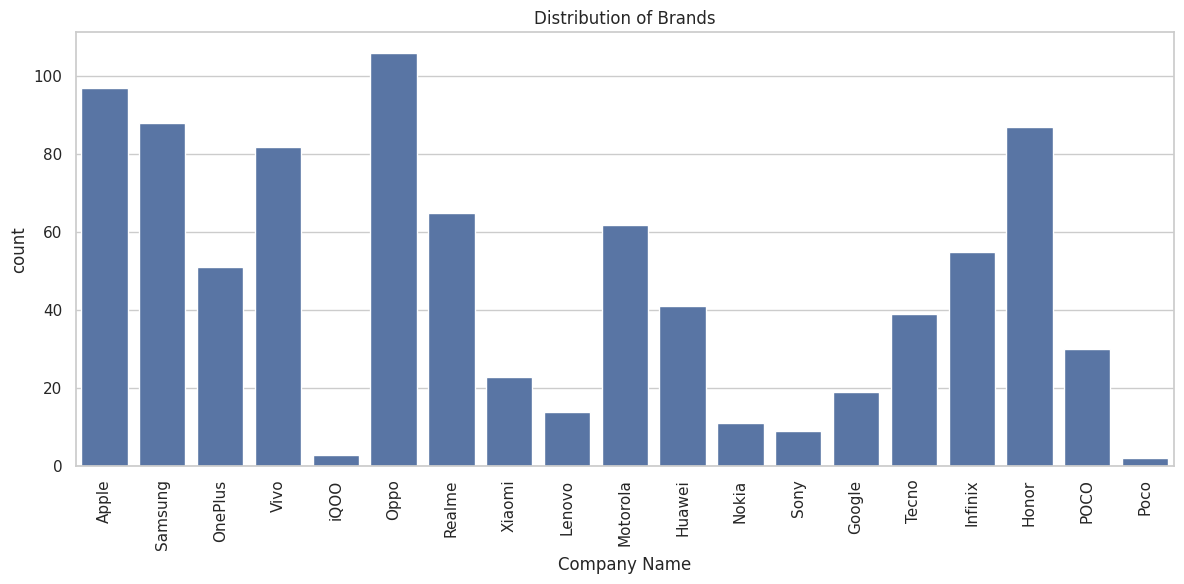

In [45]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Company Name', data=df)
plt.xticks(rotation=90)
plt.title("Distribution of Brands")
plt.tight_layout()
plt.show()

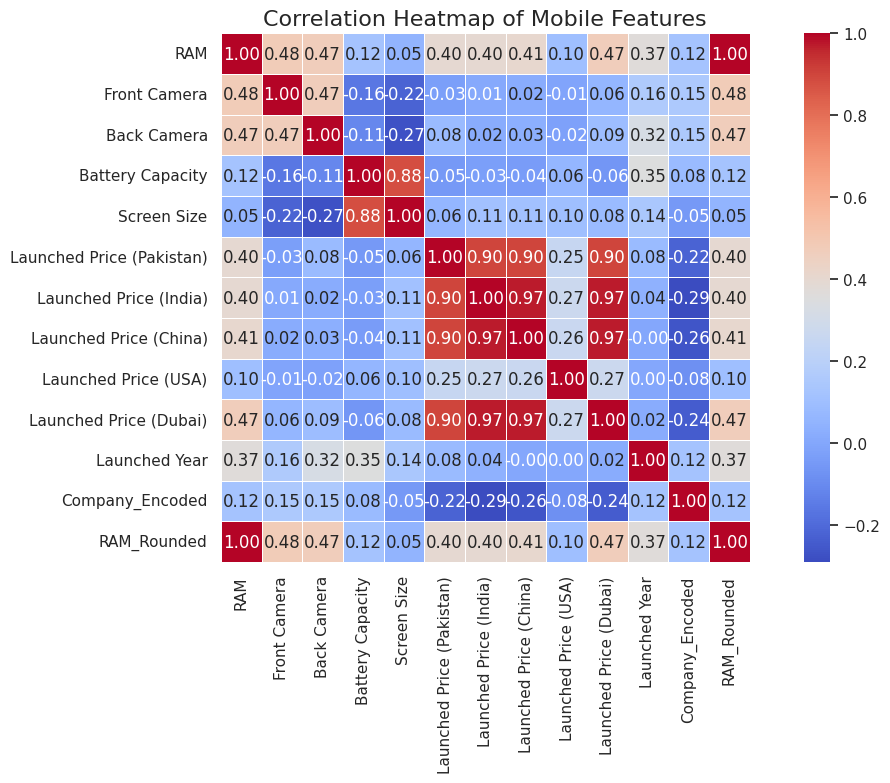

In [46]:
# Calculate correlation matrix
corr_matrix = df.corr(numeric_only=True).round(2)  # rounding for cleaner view

# Set the figure size
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, square=True, fmt='.2f')

# Add title
plt.title('Correlation Heatmap of Mobile Features', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

<ipython-input-47-f102cf302058>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Launched Price (India)'], shade=True, color="blue")


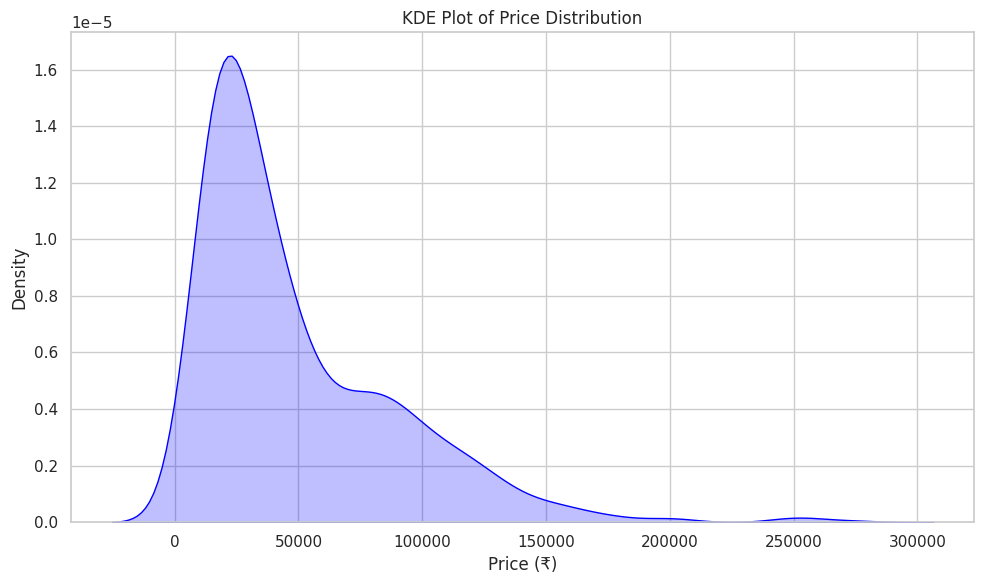

In [47]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Launched Price (India)'], shade=True, color="blue")
plt.title("KDE Plot of Price Distribution")
plt.xlabel("Price (₹)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [39]:
# Normalize all model input features
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 🎯 Feature Set
features = ['RAM', 'Screen Size', 'Battery Capacity', 'Front Camera', 'Back Camera', 'Company_Encoded']
target = 'Launched Price (India)'

X = df[features]
y = df[target]

# 📊 Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌲 Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# 📈 Evaluation
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# 🤖 Gradio Interface
!pip install gradio --quiet
import gradio as gr

# Dropdown company choices
company_list = sorted(df['Company Name'].unique().tolist())

def predict_price(ram, screen, battery, front_cam, back_cam, company_name):
    encoded_company = le.transform([company_name])[0]
    input_data = np.array([[ram, screen, battery, front_cam, back_cam, encoded_company]])
    input_scaled = scaler.transform(input_data[:, :5])  # normalize input features (exclude company)
    final_input = np.concatenate((input_scaled, input_data[:, 5:]), axis=1)  # merge with encoded company
    predicted_price = rf.predict(final_input)[0]
    return f"💰 Estimated Price in India: ₹{int(predicted_price):,}"

# Interface
iface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Slider(1, 16, step=1, label="RAM (GB)"),
        gr.Slider(4.0, 7.5, step=0.1, label="Screen Size (inches)"),
        gr.Slider(1000, 7000, step=100, label="Battery (mAh)"),
        gr.Slider(0, 64, step=1, label="Front Camera (MP)"),
        gr.Slider(5, 200, step=1, label="Back Camera (MP)"),
        gr.Dropdown(choices=company_list, label="Company Name")
    ],
    outputs="text",
    title="📱 Mobile Price Predictor (India)",
    description="Enter mobile specs to get an estimated launch price in ₹INR."
)

iface.launch(debug=True)

R² Score: 0.9195602686815829
MAE: 7746.174978205645
MSE: 135696119.79147714
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e6a9e3fa6dfd8a74f1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Using existing dataset file at: .gradio/flagged/dataset1.csv


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://e6a9e3fa6dfd8a74f1.gradio.live
